In [1]:
# Twitter data analysis task starter.
import html
import json
import string
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from textblob import TextBlob
from wordcloud import WordCloud
import pandas as pd
import matplotlib.pyplot as plt



In [2]:
# First collect the data in json-file; specify file name here (adjust the number as queried)
##fjson = 'raw_tweet_data_200.json'
fjson = 'raw_tweet_data_10000.json'

In [3]:
# read json file with tweets data
# https://docs.python.org/3/tutorial/inputoutput.html#reading-and-writing-files
with open(fjson) as file:
    data = json.load(file)
len(data)


10000

In [4]:
# tweet data record example: as documented for the Twitter API
# https://developer.twitter.com/en/docs/twitter-api/v1/data-dictionary/object-model/tweet
data[0]


{'created_at': '2022-07-26T22:21:39.000Z',
 'text': "Only one stream of Ni No Kuni left. What a journey! It's always been so fun to finish games I couldn't finish when I was younger.\n\nVideo games HAVE made me smarter, MOM! Take that!",
 'public_metrics': {'retweet_count': 0,
  'reply_count': 0,
  'like_count': 0,
  'quote_count': 0},
 'id': '1552056583194120192',
 'author_id': '543416275'}

In [5]:
# create pandas dataframe from tweet text content
# https://stackoverflow.com/a/43175477
df_tweets = pd.DataFrame([t['text'] for t in data], columns=['text'])
df_tweets


,text
0,Only one stream of Ni No Kuni left. What a jou...
1,RT @iBallisticSquid: One of my favourite thing...
2,@jondelarroz I dont think so. I think it's som...
3,playing video games makes me feel ill and i am...
4,@gunsocooI I never play video games
...,...
9995,RT @hamesatron: i want a ratatouille rat but i...
9996,"Hey everybody, I'm streaming at the moment. Co..."
9997,"RT @KyKennedyArt: Hello! I’m Ky, a concept art..."
9998,RT @elonmusk: What video games have you enjoye...


In [6]:
# add selected columns from tweet data fields
df_tweets['retweets'] = [t['public_metrics']['retweet_count'] for t in data]
df_tweets['favorites'] = [t['public_metrics']['like_count'] for t in data]
df_tweets['user'] = [t['author_id'] for t in data]
df_tweets

,text,retweets,favorites,user
0,Only one stream of Ni No Kuni left. What a jou...,0,0,543416275
1,RT @iBallisticSquid: One of my favourite thing...,8,0,1119492100918136835
2,@jondelarroz I dont think so. I think it's som...,0,0,4804382466
3,playing video games makes me feel ill and i am...,0,0,931992625518907393
4,@gunsocooI I never play video games,0,0,1535085691755024384
...,...,...,...,...
9995,RT @hamesatron: i want a ratatouille rat but i...,16,0,1296782971765219330
9996,"Hey everybody, I'm streaming at the moment. Co...",0,0,1512216060
9997,"RT @KyKennedyArt: Hello! I’m Ky, a concept art...",9,0,813492537214136321
9998,RT @elonmusk: What video games have you enjoye...,10631,0,1448974074047307791


In [7]:
# text cleaning function: see prior class modules
stop_words = set(stopwords.words('english'))

# strictly speaking, this is a closure: uses a wider-scope variable stop_words
# (disregard this note if you are a Python beginner)
def text_cleanup(s):
    s_unesc = html.unescape(re.sub(r"http\S+", "", re.sub('\n+', ' ', s)))
    s_noemoji = s_unesc.encode('ascii', 'ignore').decode('ascii')
    # normalize to lowercase and tokenize
    wt = word_tokenize(s_noemoji.lower())
    
    # filter word-tokens
    wt_filt = [w for w in wt if (w not in stop_words) and (w not in string.punctuation) and (w.isalnum())]
    
    # return clean string
    return ' '.join(wt_filt)

In [8]:
# add clean text column
# NOTE: apply in pandas applies a function to each element of the selected column
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html
df_tweets['text_clean'] = df_tweets['text'].apply(text_cleanup)
df_tweets

,text,retweets,favorites,user,text_clean
0,Only one stream of Ni No Kuni left. What a jou...,0,0,543416275,one stream ni kuni left journey always fun fin...
1,RT @iBallisticSquid: One of my favourite thing...,8,0,1119492100918136835,rt iballisticsquid one favourite things youtub...
2,@jondelarroz I dont think so. I think it's som...,0,0,4804382466,jondelarroz dont think think something deeper ...
3,playing video games makes me feel ill and i am...,0,0,931992625518907393,playing video games makes feel ill upset
4,@gunsocooI I never play video games,0,0,1535085691755024384,gunsocooi never play video games
...,...,...,...,...,...
9995,RT @hamesatron: i want a ratatouille rat but i...,16,0,1296782971765219330,rt hamesatron want ratatouille rat instead mak...
9996,"Hey everybody, I'm streaming at the moment. Co...",0,0,1512216060,hey everybody streaming moment come check play...
9997,"RT @KyKennedyArt: Hello! I’m Ky, a concept art...",9,0,813492537214136321,rt kykennedyart hello im ky concept artist ill...
9998,RT @elonmusk: What video games have you enjoye...,10631,0,1448974074047307791,rt elonmusk video games enjoyed past year two


In [9]:
# sentiment analysis
def sentim_polarity(s):
    return TextBlob(s).sentiment.polarity

def sentim_subject(s):
    return TextBlob(s).sentiment.subjectivity

df_tweets['polarity'] = df_tweets['text_clean'].apply(sentim_polarity)
df_tweets['subjectivity'] = df_tweets['text_clean'].apply(sentim_subject)
df_tweets

,text,retweets,favorites,user,text_clean,polarity,subjectivity
0,Only one stream of Ni No Kuni left. What a jou...,0,0,543416275,one stream ni kuni left journey always fun fin...,0.10000,0.066667
1,RT @iBallisticSquid: One of my favourite thing...,8,0,1119492100918136835,rt iballisticsquid one favourite things youtub...,-0.09375,0.250000
2,@jondelarroz I dont think so. I think it's som...,0,0,4804382466,jondelarroz dont think think something deeper ...,-0.03750,0.477083
3,playing video games makes me feel ill and i am...,0,0,931992625518907393,playing video games makes feel ill upset,-0.50000,1.000000
4,@gunsocooI I never play video games,0,0,1535085691755024384,gunsocooi never play video games,0.00000,0.000000
...,...,...,...,...,...,...,...
9995,RT @hamesatron: i want a ratatouille rat but i...,16,0,1296782971765219330,rt hamesatron want ratatouille rat instead mak...,0.70000,0.600000
9996,"Hey everybody, I'm streaming at the moment. Co...",0,0,1512216060,hey everybody streaming moment come check play...,0.00000,0.000000
9997,"RT @KyKennedyArt: Hello! I’m Ky, a concept art...",9,0,813492537214136321,rt kykennedyart hello im ky concept artist ill...,0.00000,0.000000
9998,RT @elonmusk: What video games have you enjoye...,10631,0,1448974074047307791,rt elonmusk video games enjoyed past year two,0.12500,0.475000


In [11]:
# define the list of brands to analyze, consistent with the search topic 
# for which the tweets were collected
brands = ['nintendo','valve','rockstar','ea']


In [13]:
# start a brand comparison dataframe 
df_brands = pd.DataFrame(brands, columns=['brand']) 
df_brands

,brand
0,nintendo
1,valve
2,rockstar
3,ea


In [23]:
# example: tweet subset mentioning a given brand
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.contains.html
df_tweets[df_tweets['text_clean'].str.contains("rockstar")]



,text,retweets,favorites,user,text_clean,polarity,subjectivity
86,@FlackChecker @RockstarGames Any blame directe...,0,0,982245792365752323,flackchecker rockstargames blame directed vide...,0.000,0.666667
577,@RockstarGames If video games are now modeled ...,0,0,1519344010917203970,rockstargames video games modeled real life ca...,0.200,0.300000
6388,@qdoggie41 @rubenlmartinezz @RickNutz @Rocksta...,0,0,2321232795,qdoggie41 rubenlmartinezz ricknutz rockstargam...,0.315,0.572500
9071,RT @AGuyWhoTweet5: @RockstarGames I miss the d...,15,0,1227734848175034368,rt aguywhotweet5 rockstargames miss days video...,0.000,0.000000
9171,RT @AGuyWhoTweet5: @RockstarGames I miss the d...,15,0,1371469319717199873,rt aguywhotweet5 rockstargames miss days video...,0.000,0.000000


In [24]:
# function to compute average sentiment of tweets mentioning a given brand
def brand_sentiment(b):
    return df_tweets[df_tweets['text_clean'].str.contains(b)]['polarity'].mean()

In [25]:
# brand sentiment comparison
df_brands['average_sentiment'] = df_brands['brand'].apply(brand_sentiment)
df_brands


,brand,average_sentiment
0,nintendo,0.147976
1,valve,0.134375
2,rockstar,0.103000
3,ea,0.127144


In [35]:
# highest sentiment tweets
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
df_tweets.sort_values(by='polarity', ascending=False).head(20)

,text,retweets,favorites,user,text_clean,polarity,subjectivity
6496,RT @stathis35121340: 💘PLAY THE BEST SEX VIDEO...,42,0,1195375805381140480,rt stathis35121340 play best sex video games p...,1.0,0.30
7791,@yaisaeko awesome. more time for me to play vi...,0,0,1372082443390312450,yaisaeko awesome time play video games,1.0,1.00
5183,RT @777liina: legendary armor for girls in vid...,623,0,455031407,rt 777liina legendary armor girls video games ...,1.0,1.00
2216,RT @777liina: legendary armor for girls in vid...,623,0,1264050714277564416,rt 777liina legendary armor girls video games ...,1.0,1.00
5174,RT @stathis35121340: 💘PLAY THE BEST SEX VIDEO...,29,0,1359515955085385734,rt stathis35121340 play best sex video games p...,1.0,0.30
3935,@TheQuartering 01: Illusionist Rebel\n- Becaus...,0,0,3009645397,thequartering 01 illusionist rebel online best...,1.0,0.65
9313,"@Niconotbianca yep! we're best friends, we cal...",0,0,1404398770993995777,niconotbianca yep best friends call often play...,1.0,0.30
2205,RT @777liina: legendary armor for girls in vid...,623,0,1305995593680994305,rt 777liina legendary armor girls video games ...,1.0,1.00
4467,RT @newLEGACYinc: the best wrestling video gam...,39,0,1374918968616517636,rt newlegacyinc best wrestling video games 202...,1.0,0.30
8711,RT @777liina: legendary armor for girls in vid...,623,0,1407405044610306056,rt 777liina legendary armor girls video games ...,1.0,1.00


In [40]:
# highest sentiment tweets
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
df_tweets.sort_values(by='polarity', ascending=True).head(20)

,text,retweets,favorites,user,text_clean,polarity,subjectivity
4392,Resident Evil Village Gold Edition Trailer #vi...,0,1,43730357,resident evil village gold edition trailer vid...,-1.0,1.0
8509,@SpiffyduzGaming @elonmusk quit wasting your l...,0,0,1464785765267824642,spiffyduzgaming elonmusk quit wasting life vid...,-1.0,1.0
5646,But realism is boring in video games.,1,1,879948198583844864,realism boring video games,-1.0,1.0
9860,RT @pwwncess: playing video games alone is s...,16,0,1411217194482954240,rt pwwncess playing video games alone boring,-1.0,1.0
1185,Que times in video games. Horrible,0,1,2983201993,que times video games horrible,-1.0,1.0
229,@DiscussingFilm I see star wars video games ar...,0,0,246046923,discussingfilm see star wars video games still...,-1.0,1.0
5925,RT @CheezeBizkits: SUNDAY SUNDAY SUNDAY!!! \n6...,4,0,1341823115836477445,rt cheezebizkits sunday sunday sunday 6pm cst ...,-1.0,1.0
2482,@RepinWolf I'm terrible at video games *procee...,0,3,481608333,repinwolf terrible video games proceeds wreck ...,-1.0,1.0
6346,"RT @HandsomeAnHeavy: Kyle Murray having that ""...",1,0,252878620,rt handsomeanheavy kyle murray study clause co...,-1.0,1.0
405,People complaining about Sheva's AI in Residen...,0,0,943589284535259136,people complaining sheva ai resident evil 5 un...,-1.0,1.0


In [39]:
# most retweeted content
df_tweets.sort_values(by='retweets', ascending=True).head(20)


,text,retweets,favorites,user,text_clean,polarity,subjectivity
0,Only one stream of Ni No Kuni left. What a jou...,0,0,543416275,one stream ni kuni left journey always fun fin...,0.100000,0.066667
5604,I s2g of all the online video games I've playe...,0,0,1251913547279470592,s2g online video games played type people gta5...,-0.400000,0.950000
5602,"like, to the dudes who might find this tweet, ...",0,1,2271205849,like dudes might find tweet imagine paying get...,0.000000,0.000000
5600,@FinalBlazed @Helexzura “MH is just trash” yea...,0,0,1521232269272309764,finalblazed helexzura mh trash yeah dont know ...,0.000000,0.000000
5599,I love to talk about cooking and recipes؟?\n\n...,0,0,1551946844770832384,love talk cooking recipes km90 km11 video games,0.500000,0.600000
5598,@KaitlynAiry Playing video games counts as wri...,0,0,829439482873065472,kaitlynairy playing video games counts writing...,0.110000,0.656667
5597,@BinnyBunches @competencefan Yay! Glad I told...,0,1,913059961567105026,binnybunches competencefan yay glad told seein...,0.233333,0.433333
5594,"Big Ben, new to nsfw twt\n(Minors do not inter...",0,6,1551944283757895680,big ben new nsfw twt minors interact 62 horny ...,0.190606,0.507576
5588,@VincentGat @JezCorden I'm always playing with...,0,0,1547026255731601409,vincentgat jezcorden always playing randoms ha...,0.000000,0.766667
5587,@Team_Valdes yea but I couldn’t see him turnin...,0,0,1267638508405080069,yea couldnt see turning got improve team get h...,0.800000,0.700000


In [38]:
# users producing most retweeted content
df_tweets.sort_values(by='retweets', ascending=False).head(20)['user']
## look up user details with userid:
## https://twitter.com/i/user/{usrid}

965      803752091332313088
4053              987047298
1952    1338635051513352192
5647    1148993240244412419
4472             1049185536
2927     782972556471140352
9343    1001641424729853955
878                39827891
8615             1038053564
5654    1273787840460197891
9881    1401283672192520192
2501              191603616
8407    1486055115635236867
2269              440930459
8403     701732210966040576
5219     742022632057544704
6806     928727275490697216
2869    1041388424564039682
2473    1333409033215152130
1305              596413167
Name: user, dtype: object

In [29]:
# combine all text for a specific brand
def brand_all_text(b):
    # https://stackoverflow.com/a/51871650
    return ' '.join(df_tweets[df_tweets['text_clean'].str.contains(b)]['text_clean'])


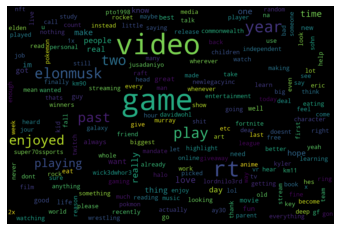

In [30]:
# most common twet content keywords for a specific brand
# https://amueller.github.io/word_cloud/auto_examples/single_word.html#sphx-glr-auto-examples-single-word-py
# https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html#wordcloud.WordCloud
b = 'ea'
wc = WordCloud(width=1200, height=800, max_font_size=110, collocations=False).generate(brand_all_text(b))
plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.show()